### Singeltask 

In [1]:
import os 
import pandas as pd

stl_results_fcn = pd.DataFrame(columns=["dataset","best_model_train_acc", "accuracy", "precision", "recall", "duration"])
stl_results_res = pd.DataFrame(columns=["dataset","best_model_train_acc", "accuracy", "precision", "recall", "duration"])

for idx, dataset in enumerate(os.listdir('./archives/ucr')):
    fcn_model = pd.read_csv(f'./results/ucr/{dataset}/fcn/fcn_1.0/original/df_best_model.csv')
    fcn_metrics = pd.read_csv(f'./results/ucr/{dataset}/fcn/fcn_1.0/original/task1_df_metrics.csv')
    res_model = pd.read_csv(f'./results/ucr/{dataset}/resnet/resnet_1.0/original/df_best_model.csv')
    res_metrics = pd.read_csv(f'./results/ucr/{dataset}/resnet/resnet_1.0/original/task1_df_metrics.csv')

    #Read STL results for FCN classifier
    stl_results_fcn.loc[idx] = [dataset, fcn_model["best_model_train_acc"].values[0], 
                                fcn_metrics["accuracy"].values[0], fcn_metrics["precision"].values[0],
                                fcn_metrics["recall"].values[0], fcn_metrics["duration"].values[0]] 
    #Read STL results for ResNet classifier
    stl_results_res.loc[idx] = [dataset, res_model["best_model_train_acc"].values[0], 
                                res_metrics["accuracy"].values[0], res_metrics["precision"].values[0],
                                res_metrics["recall"].values[0], res_metrics["duration"].values[0]] 


In [2]:
stl_results_fcn

,dataset,best_model_train_acc,accuracy,precision,recall,duration
0,GunPoint,0.480000,0.506667,0.253333,0.500000,10.021661
1,Coffee,1.000000,1.000000,1.000000,1.000000,83.390118
2,Beef,0.833333,0.366667,0.248000,0.366667,51.792605
3,Meat,0.983333,0.750000,0.803313,0.750000,83.233952
4,ECG200,1.000000,0.890000,0.887155,0.871528,41.492362
5,ECG5000,1.000000,0.939556,0.709101,0.548548,308.225050


In [3]:
stl_results_res

,dataset,best_model_train_acc,accuracy,precision,recall,duration
0,GunPoint,1.0,0.993333,0.993506,0.993243,147.183564
1,Coffee,1.0,1.000000,1.000000,1.000000,146.827705
2,Beef,1.0,0.633333,0.665195,0.633333,146.145196
3,Meat,1.0,0.916667,0.933333,0.916667,145.907373
4,ECG200,1.0,0.870000,0.870266,0.843750,146.415622
5,ECG5000,1.0,0.929556,0.675259,0.565985,863.733498


### Test Similarity of Attribution methods

- raw unscaled attribution vectors
- pearson 

In [4]:
import numpy as np
from utils.utils import read_dataset

archive = 'ucr'
dataset_name = 'GunPoint'
data_p = 'G:/Meine Ablage/master thesis/code/xai-tsc'

train_val = []
test_val  = []

for idx, dataset in enumerate(os.listdir('./archives/ucr')):
    ylen = 1
    data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]
    ylen = len(data[0][0])
    try:
        _,cy,_,cy1 = read_dataset(data_p, archive, dataset, 'fcn_cam_raw', ylen)[dataset]
        _,igy,_,igy1 = read_dataset(data_p, archive, dataset, 'fcn_ig_raw', ylen)[dataset]
        train_val.append([dataset,np.mean(np.corrcoef(cy, igy, rowvar=True))])
        test_val.append([dataset,np.mean(np.corrcoef(cy1,igy1,rowvar=True))])
    except: 
        print("import error")

    
pd.DataFrame(train_val,columns=["dataset", "correlation"])
pd.DataFrame(test_val,columns=["dataset", "correlation"])


import error


,dataset,correlation
0,GunPoint,0.029085
1,Coffee,0.317611
2,Beef,0.036095
3,Meat,0.085237
4,ECG200,0.087100


In [5]:
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
import tensorflow as tf 
def interpolate_series(baseline,
                       series,
                       alphas):
  alphas_x = alphas[:,tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(series, axis=0)
  delta = tf.expand_dims((series - baseline),axis=0)
  series = baseline_x +  alphas_x * delta
  return series

def compute_gradients(model,series,target_class):
  with tf.GradientTape() as tape:
    tape.watch(series)
    logits = model(series)[1]
  return tape.gradient(logits, series)

def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

@tf.function
def integrated_gradients(model,
                         baseline,
                         series,
                         target_class, 
                         m_steps=50,
                         batch_size=16,
                         task = 0):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
  #tf.print("ALPHAS",alphas)
  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_series(baseline=baseline,
                                                       series=series,
                                                       alphas=alpha_batch)


    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(model,interpolated_path_input_batch,target_class)

    
    #tf.print(gradient_batch)

    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    

  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  #print("AVG",(series - baseline,tf.print(avg_gradients)))
  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (series - baseline) * avg_gradients

  #tf.print(series - baseline)
  #tf.print(integrated_gradients)

  return integrated_gradients


In [79]:
import tensorflow_addons as tfa
#from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.utils import CustomObjectScope
import tensorflow.keras as keras
import tensorflow as tf
import os
from utils.explanations import minmax_norm


def load_model(root_dir, archive_name, dataset_name, classifier, data_source): 
    with CustomObjectScope({'InstanceNormalization':tfa.layers.InstanceNormalization()}):
        model_path = f'{root_dir}/results/{archive_name}/{dataset_name}/' \
                                                + f'{classifier.split("_")[0]}/{classifier}/{data_source}/' \
                                                + f'best_model.hdf5'
        model =keras.models.load_model(model_path ,compile=False)
        return model
    
from sklearn.metrics import mean_absolute_error, mean_squared_error

for idx, dataset in enumerate(os.listdir('./archives/ucr')):
    ylen = 1
    if dataset != "ECG200": 
        continue
    data = read_dataset(data_p, archive, dataset, 'original', ylen)[dataset]

    unique = np.where(data[1]==-1)[0]
    print(np.unique(data[1]))
    ylen = len(data[0][0])
    try:
        #xv,cy,_,cy1 = read_dataset(data_p, archive, dataset, 'fcn_cam_raw', ylen)[dataset]
        xv,igy,xv1,igy1 = read_dataset(data_p, archive, dataset, 'resnet_ig_raw', ylen)[dataset]
        l = f'./results/ucr/{dataset}/resnet/resnet_mt_dense/resnet_cam_raw_-1.0_1/last_model.hdf5'
        model =keras.models.load_model(l ,compile=False)
        mae = 0
        mse = 0
        corr = 0
        #print(igy.shape)
        c = 0
        for x,ya in zip(xv,igy): 
            baseline = tf.zeros(xv.shape[1])
            ig = integrated_gradients(model,baseline,x.astype('float32'),target_class=None,task=1)
            if c in unique:
                #print(c)
                #print(np.corrcoef(ig,ya)
                abs_mae = np.mean(np.absolute(np.subtract(ig.numpy().reshape(1,-1)[0],ya.reshape(1,-1))[0]))
                mae += mean_absolute_error(minmax_norm(ig),minmax_norm(ya))
                mse += mean_squared_error(minmax_norm(ig),minmax_norm(ya))
                corr += np.corrcoef(ig,ya)
                #np.corrcoef(ig,ya)
                #osine(ig,ya)
                #np.corrcoef(ig,ya)
                #cosine(ig,ya)
                #
            c+=1
        print(dataset, abs_mae/unique.shape[0])
        print(dataset, corr/unique.shape[0])
        print(dataset, mae/unique.shape[0])
        print(dataset, mse/unique.shape[0])
        #print(dataset,corr/igy.shape[0])
    except Exception as error:
        print(error)




#MAE Class 1: 
#0.17264397847706922
#0.03232592366462782


#MAE Class 2
#0.025599237671225163
#0.09025885478430559


#Meat 0.2155978515401708
#Meat 0.08914268102275488

#ECG200 0.21678610984135727
#ECG200 0.07590870065360383

#ECG200 0.2266741314014832
#ECG200 0.08104668962708873

#ECG200 0.31126915264906735
#ECG200 0.1345390868457374

#ECG200 0.2511225617491616
#ECG200 0.09312163299973342

#ECG200 0.2678260841470003
#ECG200 0.10631503301839768

#ECG200 0.20736253490200424
#ECG200 0.06882019716969784



[-1.  1.]
No file or directory found at ./results/ucr/ECG200/resnet/resnet_mt_dense/resnet_cam_raw_-1.0_1/last_model.hdf5


4/4 [==============================] - 0s 12ms/step


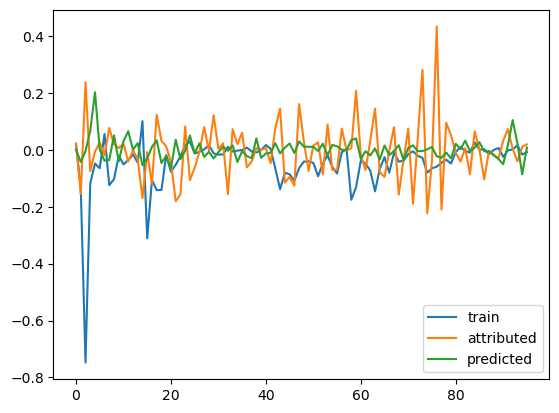

[[1.         0.12256247]
 [0.12256247 1.        ]]
1.2110277311454878


In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
from utils.explanations import minmax_norm
ts = 5

from sklearn.preprocessing import normalize

#print(normalize(igy[ts].reshape(1,-1))[0])
#print(integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1).numpy().reshape(1, -1)[0])

#print(normalize(integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1).numpy().reshape(1,-1)))

#print(normalize(igy[ts].reshape(1,-1)))
#print(cosine(normalize(igy[ts].reshape(1,-1))[0],\
#             normalize(integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1).numpy().reshape(1,-1))[0]))

#print(cosine(minmax_norm(igy[ts]),minmax_norm(integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1))))
#plt.plot(minmax_norm(igy[ts]), label="train")
#plt.plot(minmax_norm(integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1)), label="attributed")
#plt.plot(minmax_norm(model.predict(xv)[1][1].flatten()),label= "predicted")

#plt.plot(igy1[ts])
#plt.plot(integrated_gradients(model,baseline,xv1[ts].astype('float32'),target_class=None,task=1))
plt.plot(normalize(igy[ts].reshape(1,-1))[0], label="train")
plt.plot(normalize(integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1).numpy().reshape(1,-1))[0], label="attributed")
plt.plot(model.predict(xv1)[1][ts],label="predicted")


plt.legend()
plt.show()
#print(normalize(integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1).numpy().reshape(1,-1)))

print(np.corrcoef(igy1[ts],integrated_gradients(model,baseline,xv1[ts].astype('float32'),target_class=None,task=1)))
print(cosine(igy[ts],integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1)))


In [115]:
ts = 0 
ts1 = 1


a  = normalize(integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1).numpy().reshape(1,-1))[0]
b = normalize(integrated_gradients(model,baseline,xv[ts1].astype('float32'),target_class=None,task=1).numpy().reshape(1,-1))[0]

np.corrcoef(a,b)

array([[1.       , 0.9413467],
       [0.9413467, 1.       ]])

In [24]:
xv,igy,_,igy1 = read_dataset(data_p, archive, "GunPoint", 'fcn_ig_raw_1.0', ylen)["GunPoint"]

In [12]:
igy

array([[ 1.01263979e-02,  1.52722094e-02,  1.25124911e-02, ...,
         1.99665055e-02,  2.16565952e-02,  1.30488416e-02],
       [ 8.24268535e-03,  1.18876733e-02,  1.01128398e-02, ...,
         2.03650855e-02,  2.20097378e-02,  1.30212065e-02],
       [-2.56711413e-04, -9.12885516e-05,  1.77391621e-06, ...,
        -9.63151455e-04, -2.68909638e-03, -2.68535456e-03],
       ...,
       [-1.01399492e-03, -1.82567572e-03, -1.42265740e-03, ...,
        -4.69603715e-03, -1.33146131e-02, -6.72154687e-03],
       [-4.44942234e-05, -2.92218592e-05,  8.88033446e-06, ...,
        -5.11460705e-04, -6.65284868e-04, -4.25758451e-04],
       [ 1.52569897e-02,  2.32680030e-02,  1.96367782e-02, ...,
         3.31812426e-02,  3.67944315e-02,  2.26910301e-02]])

In [9]:
print(corr).mean()

[[ 1.30000000e+01  1.19985623e+00  9.48990969e-01 -2.92214607e-01
   2.11055805e-01  1.71838590e-01  9.91302894e-01 -4.18477292e-01
  -1.52273551e+00  4.30643820e+00 -3.06565799e-01 -7.02194303e-01
  -7.58295819e-02  5.44340102e-01 -2.81029294e-01  1.02039871e+00
  -1.60935151e-01  1.43006445e+00  1.56265954e+00 -4.07813202e-01
   3.49482395e+00 -7.93675398e-02 -4.74126341e-01 -2.05623042e-01
  -2.25842000e+00 -5.37230293e-02  4.12510809e+00]
 [ 1.19985623e+00  1.30000000e+01 -4.16610768e+00  2.15272611e-01
  -9.51350745e-01  3.43850747e+00  3.86869966e-01  7.49959344e-01
   5.57354079e-01  4.92964348e-01 -2.90916969e+00  1.16956536e-01
   7.41773155e-01 -9.29032096e-01 -2.52840042e+00 -1.85408226e+00
  -8.75011179e-02  4.80202079e+00 -3.25623782e+00 -4.86033618e+00
   3.34328340e+00 -2.48217165e+00 -4.08397485e+00 -6.99052099e-01
  -2.74290300e-01 -1.95872249e+00  8.62028793e-01]
 [ 9.48990969e-01 -4.16610768e+00  1.30000000e+01  1.60251011e+00
  -5.85469809e-01 -5.90711752e+00 -3.667

AttributeError: 'NoneType' object has no attribute 'mean'

array([[1.        , 0.14856735],
       [0.14856735, 1.        ]])

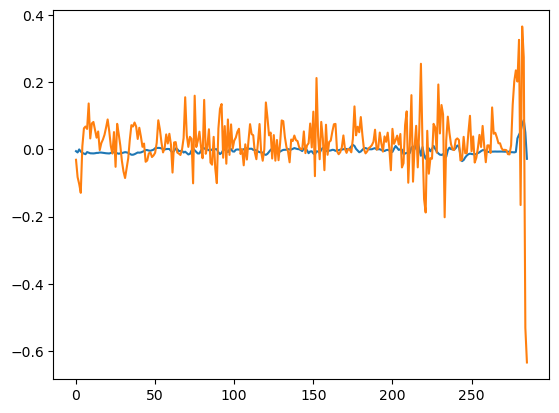

In [62]:
%matplotlib inline  
import matplotlib.pyplot as plt
plt.plot(igy[1])
plt.plot(integrated_gradients(model,baseline,xv[1].astype('float32'),target_class=None,task=1))
np.corrcoef(igy[1],integrated_gradients(model,baseline,xv[1].astype('float32'),target_class=None,task=1))

#from scipy.spatial.distance import cosine
#cosine(igy[1],integrated_gradients(model,baseline,xv[1].astype('float32'),target_class=None,task=1))

4/4 [==============================] - 0s 12ms/step


<Figure size 640x480 with 0 Axes>

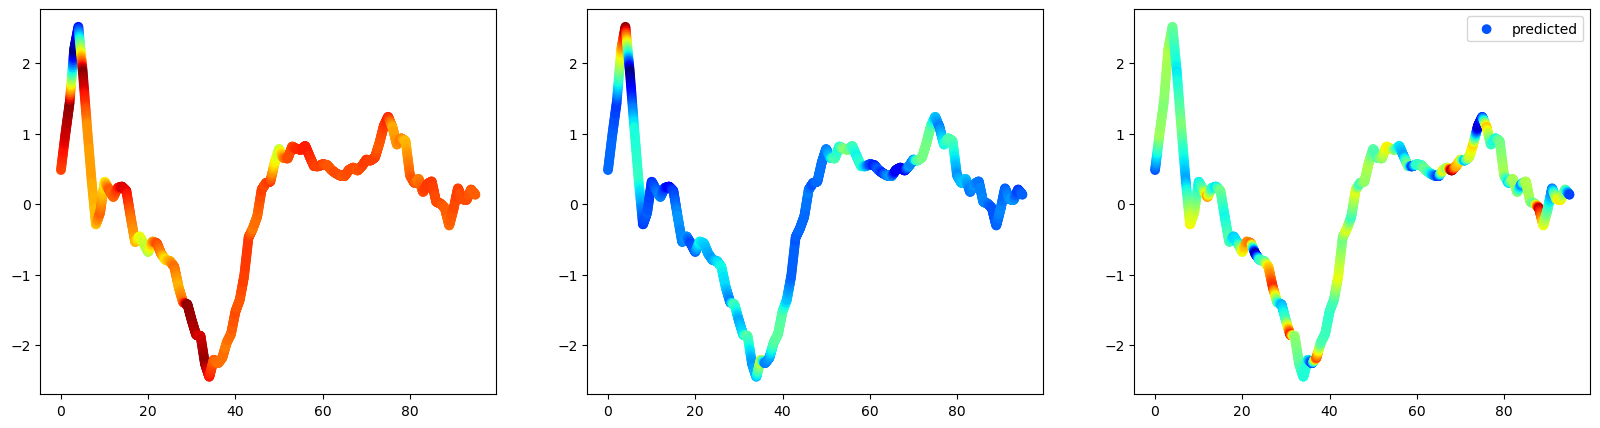

[[1.         0.07432724]
 [0.07432724 1.        ]]
4/4 [==============================] - 0s 11ms/step
[[1.         0.05551223]
 [0.05551223 1.        ]]


In [64]:
from scipy.interpolate import interp1d
def prepare_visualize_attribution(ts,attribution):
    max_length = 2000    
    #prepare values
    minimum = np.min(attribution)
    cas = attribution - minimum
    cas = cas / max(cas)
    cas = cas * 100
    xv= np.linspace(0, len(ts) - 1, max_length, endpoint=True)
    f = interp1d(range(len(ts)),ts)
    yv = f(xv)
    f = interp1d(range(len(ts)),cas)
    cas = f(xv).astype(int)
    return xv,yv,cas


ts = 10

vis1 = prepare_visualize_attribution(xv[ts],igy[ts])
vis2 = prepare_visualize_attribution(xv[ts],integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1))
vis3 = prepare_visualize_attribution(xv[ts],model.predict(xv)[1][1].flatten())

plt.figure()

fig,ax = plt.subplots(nrows=1,ncols=3, figsize=(20,5))
ax[0].scatter(vis1[0],vis1[1],c=vis1[2], cmap='jet', vmin=0,vmax=100, label="train")
ax[1].scatter(vis2[0],vis2[1],c=vis2[2], cmap='jet',  vmin=0,vmax=100, label="attributed")
ax[2].scatter(vis3[0],vis3[1],c=vis3[2], cmap='jet',  vmin=0,vmax=100, label="predicted")
plt.legend()
plt.show()

print(np.corrcoef(integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1),igy[1]))
print(np.corrcoef(model.predict(xv)[1][1].flatten(),igy[1]))

1.0147409433541903
0.16401217165161974
1/1 [==============================] - 0s 242ms/step
1.0147409409575239


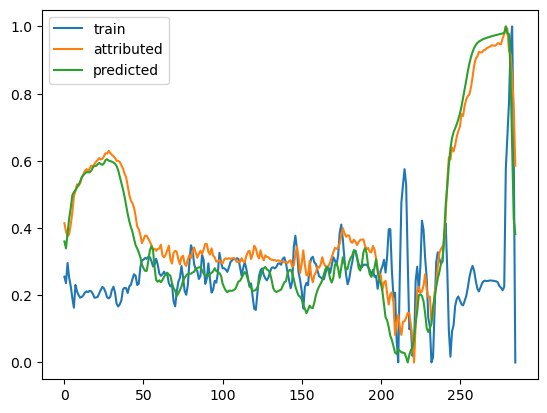

In [65]:
import matplotlib.pyplot as plt
from utils.explanations import minmax_norm
ts = 3

from sklearn.preprocessing import normalize

#print(normalize(igy[ts].reshape(1,-1))[0])
#print(integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1).numpy().reshape(1, -1)[0])
print(cosine(normalize(igy[ts].reshape(1,-1))[0],\
             normalize(integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1).numpy().reshape(1,-1))[0]))

print(cosine(minmax_norm(igy[ts]),minmax_norm(integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1))))
plt.plot(minmax_norm(igy[ts]), label="train")
plt.plot(minmax_norm(integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1)), label="attributed")
plt.plot(minmax_norm(model.predict(xv)[1][1].flatten()),label= "predicted")
plt.legend()

print(cosine(igy[ts],integrated_gradients(model,baseline,xv[ts].astype('float32'),target_class=None,task=1)))


In [11]:
model.predict(xv)[1][1].flatten().shape

1/1 [==============================] - 0s 25ms/step


(150,)

In [12]:
igy[0]

array([ 0.0101264 ,  0.01527221,  0.01251249, -0.00125663, -0.01294278,
       -0.01495118, -0.0076647 ,  0.0041213 ,  0.00669625,  0.00671449,
        0.0054273 ,  0.0054554 ,  0.00756994,  0.00857301,  0.00706078,
        0.00432045,  0.00343823,  0.00464431,  0.00581258,  0.00697873,
        0.00725913,  0.00717795,  0.0069549 ,  0.00693648,  0.00694885,
        0.0069798 ,  0.00702168,  0.00706749,  0.00710296,  0.00712793,
        0.00714617,  0.00710215,  0.00702134,  0.0068539 ,  0.00667328,
        0.00649289,  0.00653003,  0.00680982,  0.00705088,  0.00713372,
        0.00733776,  0.00748539,  0.00824441,  0.0091132 ,  0.00990563,
        0.01006806,  0.00690263,  0.00401592,  0.00126838, -0.00222182,
        0.00058418,  0.00539167,  0.01404075,  0.0203944 ,  0.01560938,
        0.01178471,  0.01391339,  0.01976081,  0.00969933,  0.00890276,
        0.04145484,  0.05048909,  0.00657214, -0.04704433, -0.06027094,
       -0.04491134,  0.01037865,  0.04931124,  0.06662203,  0.05

In [13]:
#data = read_dataset(data_p, archive, "Gun", 'original', ylen)["Beef"]
xtr,ytr,xte,yte = read_dataset(data_p, archive, "GunPoint", 'fcn_ig_raw', 150)["GunPoint"]

minmax_norm(ytr[0])

array([0.49228083, 0.51777049, 0.50410029, 0.43589526, 0.37800821,
       0.36805964, 0.40415304, 0.46253472, 0.47528968, 0.47538   ,
       0.46900397, 0.46914316, 0.4796175 , 0.48458615, 0.47709537,
       0.4635212 , 0.45915117, 0.46512545, 0.47091245, 0.47668895,
       0.47807789, 0.47767576, 0.47657092, 0.47647967, 0.47654091,
       0.47669422, 0.47690166, 0.47712861, 0.47730431, 0.477428  ,
       0.47751836, 0.47730028, 0.4769    , 0.47607058, 0.47517588,
       0.47428232, 0.4744663 , 0.47585222, 0.47704631, 0.4774567 ,
       0.47846736, 0.47919868, 0.48295847, 0.48726196, 0.49118726,
       0.49199186, 0.47631196, 0.46201271, 0.44840284, 0.43111422,
       0.4450137 , 0.46882747, 0.5116705 , 0.54314314, 0.51944066,
       0.50049523, 0.5110396 , 0.54000465, 0.49016536, 0.48621959,
       0.64746554, 0.6922165 , 0.47467488, 0.20908697, 0.14356923,
       0.21965269, 0.49353038, 0.68638206, 0.77213063, 0.71321042,
       0.53704221, 0.35673048, 0.25886216, 0.2826372 , 0.39823

In [14]:
c = 2
x,y,x1,y1 = data

train_c1 = np.concatenate((y[np.where(data[1]==c)[0]],x[np.where(data[1]==c)[0]]), axis=1)
test_c1 = np.concatenate((y1[np.where(data[3]==c)[0]],x1[np.where(data[3]==c)[0]]), axis=1)

print(train_c1.shape,test_c1.shape)


(26, 151) (74, 151)


In [15]:
np.savetxt("G:/Meine Ablage/master thesis/code/xai-tsc/archives/ucr/GunPoint/"+ "GunPoint" +  "_TRAIN", train_c1, delimiter=',')
np.savetxt("G:/Meine Ablage/master thesis/code/xai-tsc/archives/ucr/GunPoint/"+ "GunPoint" +  "_TEST", test_c1, delimiter=',')

In [16]:
#train set: 
c = 2

train_c1 = np.concatenate((ytr[np.where(data[1]==c)[0]],xtr[np.where(data[1]==c)[0]]), axis=1)

test_c1 = np.concatenate((yte[np.where(data[3]==c)[0]],xte[np.where(data[3]==c)[0]]), axis=1)

print(train_c1.shape,test_c1.shape)
#archives/ucr/GunPoint/fcn_ig_c1
np.savetxt("G:/Meine Ablage/master thesis/code/xai-tsc/archives/ucr/GunPoint/fcn_ig_c2/"+ "GunPoint" +  "_TRAIN", train_c1, delimiter=',')
np.savetxt("G:/Meine Ablage/master thesis/code/xai-tsc/archives/ucr/GunPoint/fcn_ig_c2/"+ "GunPoint" +  "_TEST", test_c1, delimiter=',')

(26, 300) (74, 300)


In [17]:
s1 = np.loadtxt("G:/Meine Ablage/master thesis/code/xai-tsc/archives/ucr/GunPoint/fcn_ig_c1/"+ "GunPoint" +  "_TRAIN", delimiter=',').shape
s2 = np.loadtxt("G:/Meine Ablage/master thesis/code/xai-tsc/archives/ucr/GunPoint/fcn_ig_raw/"+ "GunPoint" +  "_TRAIN", delimiter=',').shape

print(s1,s2)

(24, 300) (50, 300)
